# Various statistical distributions

### Peter Onyisi

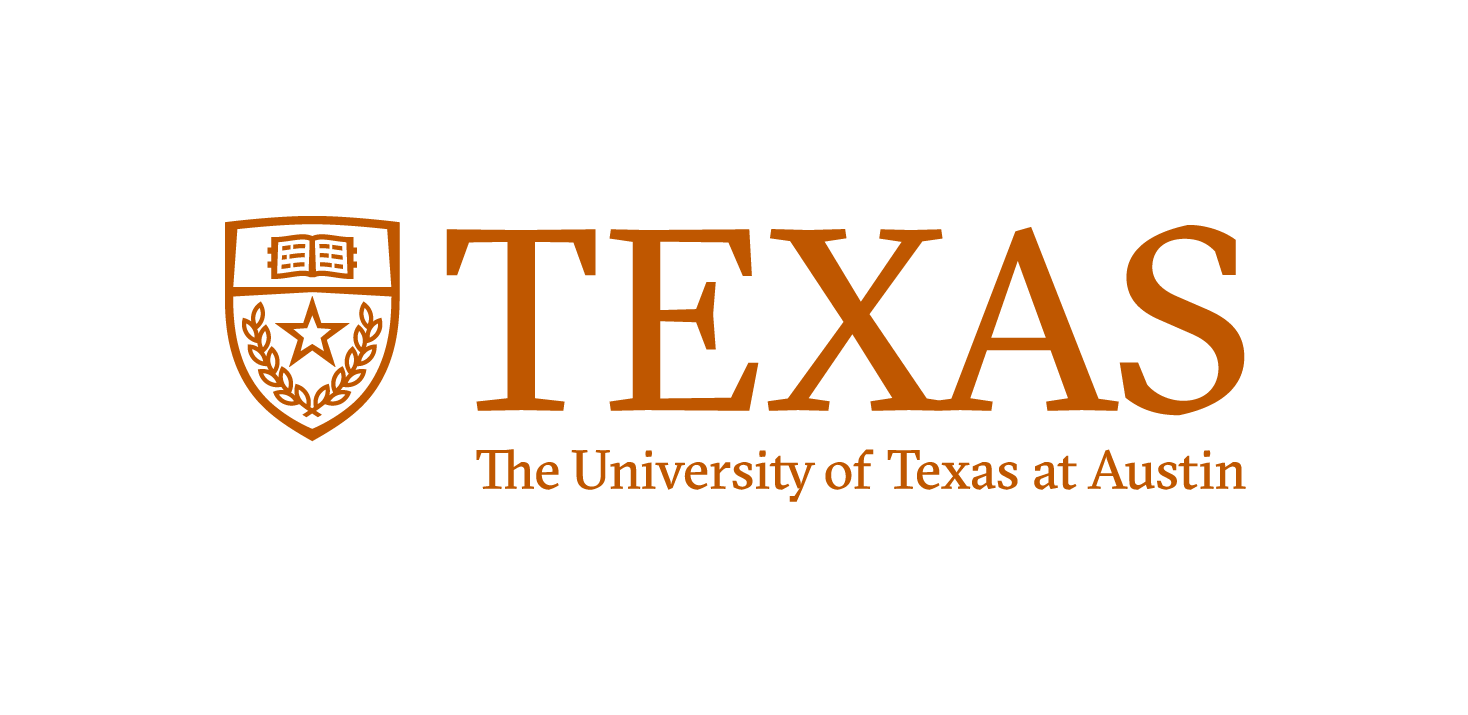

In [80]:
from matplotlib import pyplot
import numpy
from math import sqrt
import math

## Histograms

Histograms are a way of taking measurements and seeing how they are distributed.  You define a number of bins and count the number of measurements with value inside the bin.

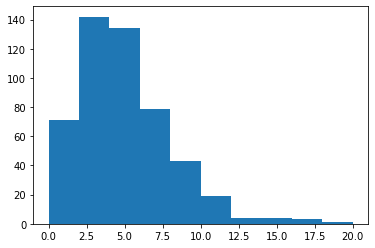

In [110]:
from matplotlib import pyplot
# hard-code some points
data = [ 5.57196602,  4.29252197,  3.58230678,  5.4081897 ,  2.15401129,
        1.26880076,  5.65695726,  1.13519392,  1.16950315,  4.06301538,
       14.96802407,  6.59339588,  1.58367746, 14.86582906,  3.6156441 ,
        2.41209319,  2.74711184,  9.665886  ,  5.56947102,  2.38748888,
        1.69379924,  6.72222678,  9.61148056,  2.52400975,  2.34166035]
# or: generate some points
data = numpy.random.chisquare(df=5, size=500)
pyplot.hist(data, range=(0,20), bins=10)
pyplot.draw()

## Probability Functions

Assume we have some process that can produce different outcomes in some probabilistic manner. We would like to describe the probability in a mathematical way.

We do this with _probability density functions_ (PDF) if the outcome is measured with a continuous variable, like a length, or _probability mass functions_ (PMF) if the outcome is discrete, like how many times an event occurred.  (In practice, both are often called PDFs).

Some rules:

| Rule | PDF _P_  | PMF _P_  |
| ---- | ------- | ------- |
| Probabilities are not negative | _P_(x) &ge; 0 | _P_(x) &ge; 0 |
| Total probability is 1 (something happens) | &int; _P_(x) dx = 1 | &sum; _P_(x) = 1 |

Note that x could be a point in multi-dimensional space (for example, the three components of a vector, or measurements from two different devices).

### Simple Example: Uniform Distribution

This has equal probability of taking on any of the allowed values (the range needs to be limited so that the probability is > 0).

* Continuous PDF:
$P(x) = \frac{1}{x_\mathrm{max}-x_\mathrm{min}}$
* Discrete PMF:
$P(x) = \frac{1}{N}$, where $N$ is the number of outcomes

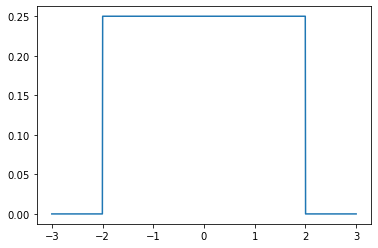

In [21]:
# Continuous uniform distribution
from matplotlib import pyplot
import numpy

# uniform over (-2,2)
def uniform(x):
    return 1./(2.-(-2.)) if -2 < x < 2 else 0.

xpoints = numpy.linspace(-3, 3, 1000)

# frompyfunc gives us a new function that allows us to apply the "uniform" function on the array of inputs
pyplot.plot(xpoints, numpy.frompyfunc(uniform, 1, 1)(xpoints))
pyplot.show()

### Generating random variables: accept-reject sampling

There are clever ways to generate a sequence of random variables following specific probability distributions; however they generally rely on knowing the integral of the probability distribution and can be tricky to code.  One simple technique that works with almost all distributions - but can be computationally inefficient - is called accept-reject sampling.  It works like this in one dimension:
* your probability distribution $P(x)$ needs to be zero outside a finite range of $x$: say $x_\mathrm{min}$ to $x_\mathrm{max}$.  You also need to know a number $M$ such that $P(x) < M$ for the whole range.  ($M$ does not need to be the smallest such number.)
* in a loop, until you've generated enough numbers:
 * generate a random number $x_\mathrm{test}$ from a uniform distribution from $x_\mathrm{min}$ to $x_\mathrm{max}$: any random number generator can provide this.  (At worst it'll provide numbers in (0,1) and you'll have to scale them to the appropriate range.)
 * compute $y = P(x_\mathrm{test})/M$.
 * generate a random number $y_\mathrm{test}$ from a uniform distribution from 0 to 1.
 * if $y_\mathrm{test} < y$, you _accept_ $x_\mathrm{test}$ and add it to your sequence. If $y \ge y_\mathrm{test}$ you _reject_ $x_\mathrm{test}$.
 * go back to start of loop to try again.
 
One nice feature is that the PDF does not need to be properly normalized: the shape is all you need.

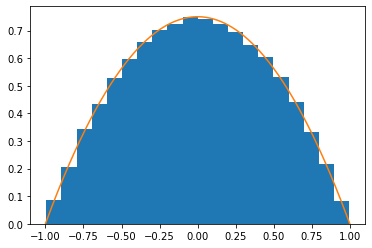

In [112]:
# this is a "generator" function: it can be used as an interator
# this is indicated by the "yield" in place of "return"
def accept_reject(func, rng, maxval):
    from random import uniform
    while True:
        xtest = uniform(*rng)
        y = func(xtest)/maxval
        ytest = uniform(0,1)
        if ytest < y:
            yield xtest
            
# some crazy PDF:
def quadratic(x):
    return 0.75*(1.-x*x) if -1 < x < 1 else 0

# some points:
from itertools import islice
generated_points = list(islice(accept_reject(quadratic, (-1,1), 1), 50000))

# compare histogram of generated points to PDF
pyplot.hist(generated_points, bins=20, density=True)
pyplot.plot(numpy.linspace(-1,1,1000), numpy.frompyfunc(quadratic, 1, 1)(numpy.linspace(-1,1,1000)))
pyplot.show()

## The Central Limit Theorem

### What happens when we add together random variables?

Imagine we want to estimate the probability distribution of a measurement error using an apparatus. One can imagine that there are a lot of small errors that combine together: a misadjustment of one part, a miscalibration of another, even the difficulty of a human reading an analog dial accurately.  How could we possibly quantify the sum of such effects whose PDFs are probably quite different?

Let's take the uniform PDF on (-1,1) and add together N random variables distributed that way to form a new random variable, the total measurement error.  Then let's make a histogram over a number of trials to see how this is distributed.

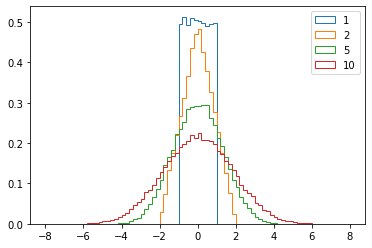

In [113]:
def multi_uniform(N):
    from random import uniform
    while True:
        yield sum(uniform(-1,1) for _ in range(N))

for N in [1, 2, 5, 10]:
    generated_points = list(islice(multi_uniform(N), 50000))
    pyplot.hist(generated_points, density=True, range=(-8,8), bins=80, histtype='step', label=str(N))
pyplot.legend()
pyplot.draw()

Apparently the sum of the variables turns into a lumpy smear.  What about some other distribution, say this weird one that is peaked away from 0?

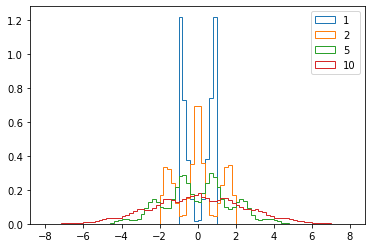

In [114]:
def hornsfunc(x):
    return 1.5*x*x if -1 <= x <= 1 else 0

def multi_hornsfunc(N):
    while True:
        yield sum(islice(accept_reject(hornsfunc, (-1, 1), 1.5), N))
        
for N in [1, 2, 5, 10]:
    generated_points = list(islice(multi_hornsfunc(N), 50000))
    pyplot.hist(generated_points, density=True, range=(-8,8), bins=80, histtype='step', label=str(N))
pyplot.legend()
pyplot.draw()

After adding N=10 variables with this distribution, the sum has turned into a lumpy smear, with a very similar shape to that created by the uniform distribution. In fact, we can show that for both these distributions, the shapes at large N converge to a common form, if we plot as a function of x/&radic;N:

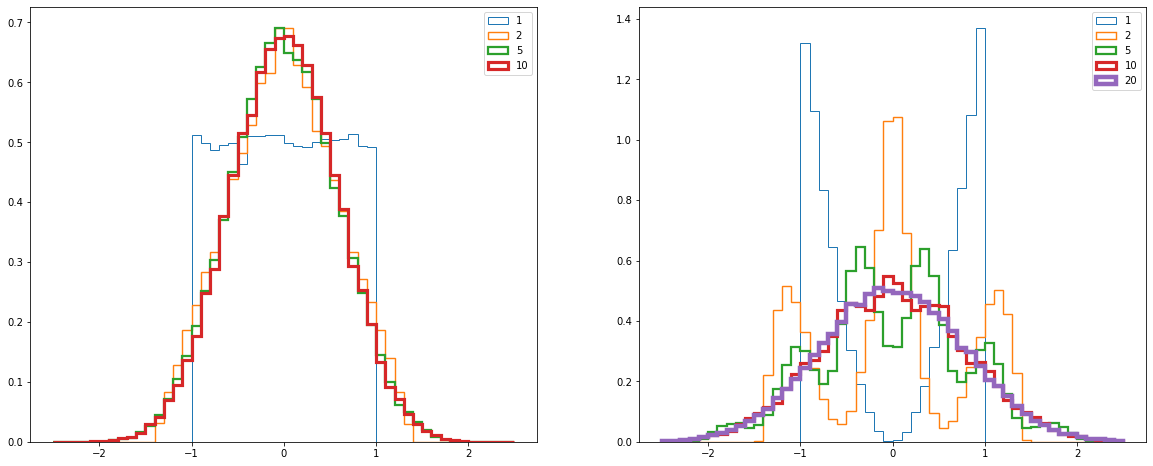

In [115]:
pyplot.figure(figsize=(20,8))
pyplot.subplot(1,2,1)
for N in [1, 2, 5, 10]:
    generated_points = numpy.array(list(islice(multi_uniform(N), 50000)))/sqrt(N)
    pyplot.hist(generated_points, density=True, range=(-2.5,2.5), bins=50, histtype='step', label=str(N), linewidth=sqrt(N))
pyplot.legend()

pyplot.subplot(1,2,2)
for N in [1, 2, 5, 10,20]:
    generated_points = numpy.array(list(islice(multi_hornsfunc(N), 50000)))/sqrt(N)
    pyplot.hist(generated_points, density=True, range=(-2.5,2.5), bins=50, histtype='step', label=str(N), linewidth=sqrt(N))
pyplot.legend()

pyplot.draw()

The function to which the sum of random variables converges is the extremely important _normal_ or _Gaussian_ distribution:

$$G(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-(x-\mu)^2/2\sigma^2}$$

where $x$ is the random variable and $\mu$ and $\sigma$ are _parameters_ (called the mean and the standard deviation). $\mu$ determines where the center of the distribution is located, and $\sigma$ determines how wide it is.

The _Central Limit Theorem_ is, roughly speaking, the statement that the probability distribution of a sum of a large number of random variables approaches a Gaussian distribution with appropriate $\mu$ and $\sigma$.  

This gives us a reason to think that experimental errors that are composed of many components can reasonably be modeled as having Gaussian distributions.

It also means that if we determine the mean of N experimental observations of the same quantity, we should expect the mean to be Gaussian-distributed if N is sufficiently large.

## Binomial distribution

Let's say I have a process that has one of two outcomes (A or B, Yes or No, ...), where I know that A happens with probability $p$ (and hence B happens with probability $1-p$).  If we try the process $N$ times, what is the probability of seeing $k$ occurrences of A?

The binomial distribution is the probability mass function for this situation.  It can be written out exactly:

$$ B(k; N, p) = p^k (1-p)^{N-k} \frac{N!}{k! (N-k)!} $$

To understand this formula: the number of distinct sequences of A and B results that have $k$ A and $N-k$ B is $N!/(k!(N-k)!)$. Each of these has a probability $p^k (1-p)^{N-k}$ of happening.

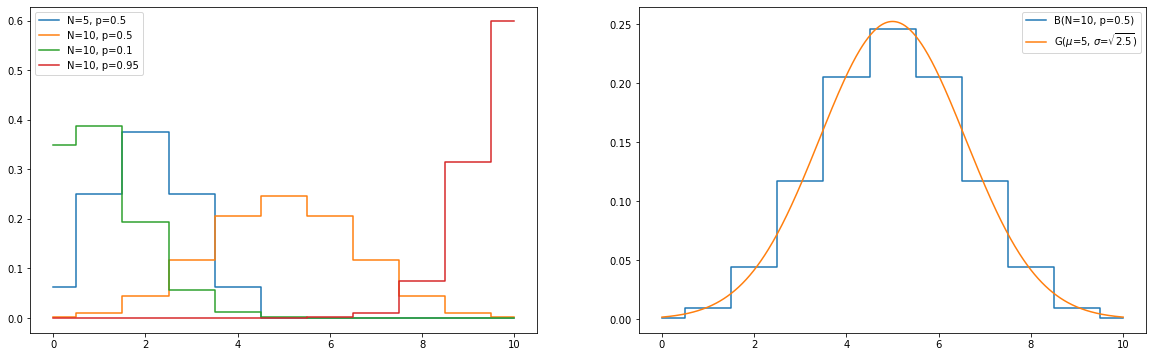

In [116]:
# the following is the most brute-force computation and will fail badly for large N due to machine precision
# see later for a smarter approach
def binomial(k, N, p):
    from math import factorial
    if not 0 <= k <= N: return 0
    return p**k * (1-p)**(N-k) * factorial(N) / (factorial(k) * factorial(N-k))

pyplot.figure(figsize=(20,6))
pyplot.subplot(1,2,1)
pyplot.step(list(range(11)), [binomial(_, 4, 0.5) for _ in range(11)], where='mid', label='N=5, p=0.5')
pyplot.step(list(range(11)), [binomial(_, 10, 0.5) for _ in range(11)], where='mid', label='N=10, p=0.5')
pyplot.step(list(range(11)), [binomial(_, 10, 0.1) for _ in range(11)], where='mid', label='N=10, p=0.1')
pyplot.step(list(range(11)), [binomial(_, 10, 0.95) for _ in range(11)], where='mid', label='N=10, p=0.95')
pyplot.legend()

pyplot.subplot(1,2,2)
pyplot.step(list(range(11)), [binomial(_, 10, 0.5) for _ in range(11)], where='mid', label='B(N=10, p=0.5)')
pyplot.plot(numpy.linspace(0, 10, 500), 1./sqrt(2*math.pi*2.5)*numpy.exp(-(numpy.linspace(0, 10, 500)-5.)**2/5), 
            label='G($\mu$=5, $\sigma$=$\sqrt{2.5}$)')
pyplot.legend()
pyplot.draw()

Some interesting features of the binomial distribution that we can already see:
* if $p$ is not too close to 0 or 1, even for $N =$ 5 or 10 the distribution already begins to look Gaussian
* for $p$ close to 0 or 1, the Gaussian approximation is not great (the observed number of successes $k$ cannot be less than zero or more than $N$)
* the mean number of successes is $pN$

It can be shown that if k and N-k are both "large" (more than a few) then a Gaussian function is a very good approximation to a binomial distribution:

$$ B(k; N, p) \sim G(k; Np, \sqrt{Np(1-p)}) $$

## A smarter approach for computing binomial probabilities, etc.

The likelihood that you actually have to do this is pretty low! But it's interesting from the perspective of the mathematical trick involved.

Direct evaluation of the factorial is troublesome if the language you are programming in does not support arbitrary-length integers (Python does, but C++ does not); even if it does, this will tend to be slow.  Much better to instead evaluate the logarithm of the probability - this ensures that all relevant numbers are reasonably small.  (For example, 100000! has 456574 digits, but $\ln 100000! = 1051299$.)

$$ \ln B(k ; N, p) = k \ln p + (N-k) \ln (1-p) + \ln N! - \ln k! - \ln (N-k)! $$

To evaluate the $\ln N!$ and similar terms, you can either 
* directly use Stirling's approximation ($\ln N! \approx N \ln N - N + \frac{1}{2}\ln 2\pi N + \ldots$)
* take advantage of the fact that many language libraries provide a function to compute the value $\ln \Gamma(x) = \ln (x-1)!$ (e.g. in Python, this is math.lgamma).

## Poisson distribution

Many processes can be described as a series of independent events with some probability to occur in a certain time. The classic example is radioactive decay: a nucleus has a 50% probability of decaying within one half life; if it survives it has a 50% probability of decaying in the next half life, and so on (it has no memory of the past).  The decay of one nucleus has no relationship with the decay of any other (independent events). If we have a lot of nuclei and look at their decays on a time scale short compared to their half life, then the number of nuclei available to decay is essentially constant.

Processes like this are termed _Poisson processes_.  We can determine the formula for the probability mass function of how many events (e.g. decays) $k$ occur in a given time by turning it into a binomial process.  Assume the mean number of events that occur in the allotted time is $\lambda$. Slice the total time into a very large number of slices $N$, where each slice is so short that we expect at most one event to happen (in the end we want $N \to \infty$).  The probability $p$ of an event in each time slice is $\lambda/N$.  So the total number of events ("successes") in the $N$ slices will follow the distribution

$$ P(k; \lambda) \sim B(k; N, \lambda/N) = (\lambda/N)^k (1-\lambda/N)^{N-k} \frac{N!}{k!(N-k)!} $$

With a little limit evaluation, one can show that as $N \to \infty$, the function converges to

$$ P(k; \lambda) = \frac{\lambda^k}{k!} e^{-\lambda} $$

For sufficiently large $\lambda$, the Poisson distribution starts to look like a Gaussian (of course!) with standard deviation $\sqrt{\lambda} = \lim_{N \to \infty} \sqrt{N(\lambda/N)(1-\lambda/N)}$.  (Note that Poisson distributions have a high side tail - you can't have less than zero events, but there's some probability to have a very large number of events.)

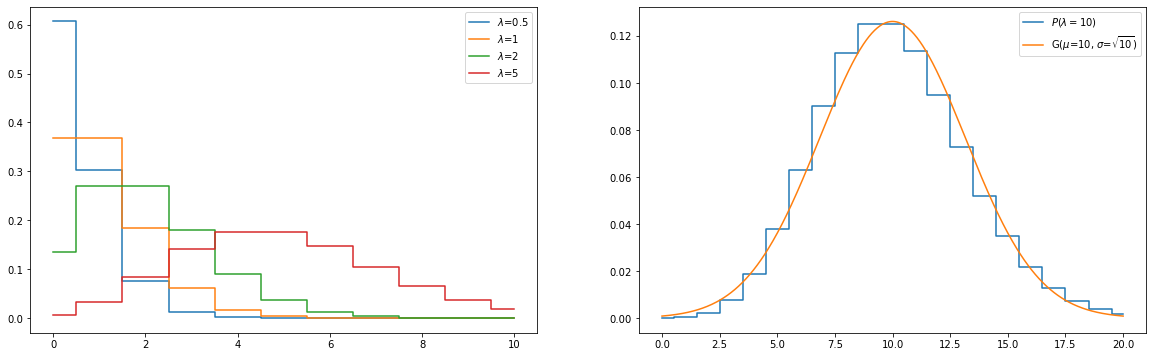

In [117]:
# we'll actually calculate log-Poisson, then exponentiate for the result
def poisson(k, lmb):
    from math import lgamma, exp, log
    if not 0 <= k: return 0
    return exp(k*log(lmb) - lgamma(k+1) - lmb)

pyplot.figure(figsize=(20,6))
pyplot.subplot(1,2,1)
pyplot.step(list(range(11)), [poisson(_, 0.5) for _ in range(11)], where='mid', label='$\lambda$=0.5')
pyplot.step(list(range(11)), [poisson(_, 1) for _ in range(11)], where='mid', label='$\lambda$=1')
pyplot.step(list(range(11)), [poisson(_, 2) for _ in range(11)], where='mid', label='$\lambda$=2')
pyplot.step(list(range(11)), [poisson(_, 5) for _ in range(11)], where='mid', label='$\lambda$=5')
pyplot.legend()

pyplot.subplot(1,2,2)
pyplot.step(list(range(21)), [poisson(_, 10) for _ in range(21)], where='mid', label='$P(\lambda=10)$')
pyplot.plot(numpy.linspace(0, 20, 500), 1./sqrt(2*math.pi*10)*numpy.exp(-(numpy.linspace(0, 20, 500)-10.)**2/20), 
            label='G($\mu$=10, $\sigma$=$\sqrt{10}$)')
pyplot.legend()
pyplot.draw()